## Visualization of 2d and 3d npz files generated for Human3.6M:

In [1]:
# VideoPose3D/common/camera.py
# Copyright (c) 2018-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import numpy as np
import torch

# from common.utils import wrap
# from common.quaternion import qrot, qinverse

def normalize_screen_coordinates(X, w, h): 
    assert X.shape[-1] == 2
    
    # Normalize so that [0, w] is mapped to [-1, 1], while preserving the aspect ratio
    return X/w*2 - [1, h/w]

    
def image_coordinates(X, w, h):
    assert X.shape[-1] == 2
    
    # Reverse camera frame normalization
    return (X + [1, h/w])*w/2
    

def world_to_camera(X, R, t):
    Rt = wrap(qinverse, R) # Invert rotation
    return wrap(qrot, np.tile(Rt, (*X.shape[:-1], 1)), X - t) # Rotate and translate

    
def camera_to_world(X, R, t):
    return wrap(qrot, np.tile(R, (*X.shape[:-1], 1)), X) + t

    
def project_to_2d(X, camera_params):
    """
    Project 3D points to 2D using the Human3.6M camera projection function.
    This is a differentiable and batched reimplementation of the original MATLAB script.
    
    Arguments:
    X -- 3D points in *camera space* to transform (N, *, 3)
    camera_params -- intrinsic parameteres (N, 2+2+3+2=9)
    """
    assert X.shape[-1] == 3
    assert len(camera_params.shape) == 2
    assert camera_params.shape[-1] == 9
    assert X.shape[0] == camera_params.shape[0]
    
    while len(camera_params.shape) < len(X.shape):
        camera_params = camera_params.unsqueeze(1)
        
    f = camera_params[..., :2]
    c = camera_params[..., 2:4]
    k = camera_params[..., 4:7]
    p = camera_params[..., 7:]
    
    XX = torch.clamp(X[..., :2] / X[..., 2:], min=-1, max=1)
    r2 = torch.sum(XX[..., :2]**2, dim=len(XX.shape)-1, keepdim=True)

    radial = 1 + torch.sum(k * torch.cat((r2, r2**2, r2**3), dim=len(r2.shape)-1), dim=len(r2.shape)-1, keepdim=True)
    tan = torch.sum(p*XX, dim=len(XX.shape)-1, keepdim=True)

    XXX = XX*(radial + tan) + p*r2
    
    return f*XXX + c

def project_to_2d_linear(X, camera_params):
    """
    Project 3D points to 2D using only linear parameters (focal length and principal point).
    
    Arguments:
    X -- 3D points in *camera space* to transform (N, *, 3)
    camera_params -- intrinsic parameteres (N, 2+2+3+2=9)
    """
    assert X.shape[-1] == 3
    assert len(camera_params.shape) == 2
    assert camera_params.shape[-1] == 9
    assert X.shape[0] == camera_params.shape[0]
    
    while len(camera_params.shape) < len(X.shape):
        camera_params = camera_params.unsqueeze(1)
        
    f = camera_params[..., :2]
    c = camera_params[..., 2:4]
    
    XX = torch.clamp(X[..., :2] / X[..., 2:], min=-1, max=1)
    
    return f*XX + c

In [2]:
# VideoPose3D/common/skeleton.py
# Copyright (c) 2018-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import numpy as np

class Skeleton:
    def __init__(self, parents, joints_left, joints_right):
        assert len(joints_left) == len(joints_right)
        
        self._parents = np.array(parents)
        self._joints_left = joints_left
        self._joints_right = joints_right
        self._compute_metadata()
    
    def num_joints(self):
        return len(self._parents)
    
    def parents(self):
        return self._parents
    
    def has_children(self):
        return self._has_children
    
    def children(self):
        return self._children
    
    def remove_joints(self, joints_to_remove):
        """
        Remove the joints specified in 'joints_to_remove'.
        """
        valid_joints = []
        for joint in range(len(self._parents)):
            if joint not in joints_to_remove:
                valid_joints.append(joint)

        for i in range(len(self._parents)):
            while self._parents[i] in joints_to_remove:
                self._parents[i] = self._parents[self._parents[i]]
                
        index_offsets = np.zeros(len(self._parents), dtype=int)
        new_parents = []
        for i, parent in enumerate(self._parents):
            if i not in joints_to_remove:
                new_parents.append(parent - index_offsets[parent])
            else:
                index_offsets[i:] += 1
        self._parents = np.array(new_parents)
        
        
        if self._joints_left is not None:
            new_joints_left = []
            for joint in self._joints_left:
                if joint in valid_joints:
                    new_joints_left.append(joint - index_offsets[joint])
            self._joints_left = new_joints_left
        if self._joints_right is not None:
            new_joints_right = []
            for joint in self._joints_right:
                if joint in valid_joints:
                    new_joints_right.append(joint - index_offsets[joint])
            self._joints_right = new_joints_right

        self._compute_metadata()
        
        return valid_joints
    
    def joints_left(self):
        return self._joints_left
    
    def joints_right(self):
        return self._joints_right
        
    def _compute_metadata(self):
        self._has_children = np.zeros(len(self._parents)).astype(bool)
        for i, parent in enumerate(self._parents):
            if parent != -1:
                self._has_children[parent] = True

        self._children = []
        for i, parent in enumerate(self._parents):
            self._children.append([])
        for i, parent in enumerate(self._parents):
            if parent != -1:
                self._children[parent].append(i)

In [3]:
#VideoPose3D/common/mocap_dataset.py
# Copyright (c) 2018-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import numpy as np
# from common.skeleton import Skeleton

class MocapDataset:
    def __init__(self, fps, skeleton):
        self._skeleton = skeleton
        self._fps = fps
        self._data = None # Must be filled by subclass
        self._cameras = None # Must be filled by subclass
    
    def remove_joints(self, joints_to_remove):
        kept_joints = self._skeleton.remove_joints(joints_to_remove)
        for subject in self._data.keys():
            for action in self._data[subject].keys():
                s = self._data[subject][action]
                if 'positions' in s:
                    s['positions'] = s['positions'][:, kept_joints]
                
        
    def __getitem__(self, key):
        return self._data[key]
        
    def subjects(self):
        return self._data.keys()
    
    def fps(self):
        return self._fps
    
    def skeleton(self):
        return self._skeleton
        
    def cameras(self):
        return self._cameras
    
    def supports_semi_supervised(self):
        # This method can be overridden
        return False

#### Camera parameters:

In [4]:
# VideoPose3D/common/h36m_dataset.py
# Copyright (c) 2018-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import numpy as np
import copy
# from common.skeleton import Skeleton
# from common.mocap_dataset import MocapDataset
# from common.camera import normalize_screen_coordinates, image_coordinates
       
h36m_skeleton = Skeleton(parents=[-1,  0,  1,  2,  3,  4,  0,  6,  7,  8,  9,  0, 11, 12, 13, 14, 12,
       16, 17, 18, 19, 20, 19, 22, 12, 24, 25, 26, 27, 28, 27, 30],
       joints_left=[6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23],
       joints_right=[1, 2, 3, 4, 5, 24, 25, 26, 27, 28, 29, 30, 31])

h36m_cameras_intrinsic_params = [
    {
        'id': '54138969',
        'center': [512.54150390625, 515.4514770507812],
        'focal_length': [1145.0494384765625, 1143.7811279296875],
        'radial_distortion': [-0.20709891617298126, 0.24777518212795258, -0.0030751503072679043],
        'tangential_distortion': [-0.0009756988729350269, -0.00142447161488235],
        'res_w': 1000,
        'res_h': 1002,
        'azimuth': 70, # Only used for visualization
    },
    {
        'id': '55011271',
        'center': [508.8486328125, 508.0649108886719],
        'focal_length': [1149.6756591796875, 1147.5916748046875],
        'radial_distortion': [-0.1942136287689209, 0.2404085397720337, 0.006819975562393665],
        'tangential_distortion': [-0.0016190266469493508, -0.0027408944442868233],
        'res_w': 1000,
        'res_h': 1000,
        'azimuth': -70, # Only used for visualization
    },
    {
        'id': '58860488',
        'center': [519.8158569335938, 501.40264892578125],
        'focal_length': [1149.1407470703125, 1148.7989501953125],
        'radial_distortion': [-0.2083381861448288, 0.25548800826072693, -0.0024604974314570427],
        'tangential_distortion': [0.0014843869721516967, -0.0007599993259645998],
        'res_w': 1000,
        'res_h': 1000,
        'azimuth': 110, # Only used for visualization
    },
    {
        'id': '60457274',
        'center': [514.9682006835938, 501.88201904296875],
        'focal_length': [1145.5113525390625, 1144.77392578125],
        'radial_distortion': [-0.198384091258049, 0.21832367777824402, -0.008947807364165783],
        'tangential_distortion': [-0.0005872055771760643, -0.0018133620033040643],
        'res_w': 1000,
        'res_h': 1002,
        'azimuth': -110, # Only used for visualization
    },
]

h36m_cameras_extrinsic_params = {
    'S1': [
        {
            'orientation': [0.1407056450843811, -0.1500701755285263, -0.755240797996521, 0.6223280429840088],
            'translation': [1841.1070556640625, 4955.28466796875, 1563.4454345703125],
        },
        {
            'orientation': [0.6157187819480896, -0.764836311340332, -0.14833825826644897, 0.11794740706682205],
            'translation': [1761.278564453125, -5078.0068359375, 1606.2650146484375],
        },
        {
            'orientation': [0.14651472866535187, -0.14647851884365082, 0.7653023600578308, -0.6094175577163696],
            'translation': [-1846.7777099609375, 5215.04638671875, 1491.972412109375],
        },
        {
            'orientation': [0.5834008455276489, -0.7853162288665771, 0.14548823237419128, -0.14749594032764435],
            'translation': [-1794.7896728515625, -3722.698974609375, 1574.8927001953125],
        },
    ],
    'S2': [
        {},
        {},
        {},
        {},
    ],
    'S3': [
        {},
        {},
        {},
        {},
    ],
    'S4': [
        {},
        {},
        {},
        {},
    ],
    'S5': [
        {
            'orientation': [0.1467377245426178, -0.162370964884758, -0.7551892995834351, 0.6178938746452332],
            'translation': [2097.3916015625, 4880.94482421875, 1605.732421875],
        },
        {
            'orientation': [0.6159758567810059, -0.7626792192459106, -0.15728192031383514, 0.1189815029501915],
            'translation': [2031.7008056640625, -5167.93310546875, 1612.923095703125],
        },
        {
            'orientation': [0.14291371405124664, -0.12907841801643372, 0.7678384780883789, -0.6110143065452576],
            'translation': [-1620.5948486328125, 5171.65869140625, 1496.43701171875],
        },
        {
            'orientation': [0.5920479893684387, -0.7814217805862427, 0.1274748593568802, -0.15036417543888092],
            'translation': [-1637.1737060546875, -3867.3173828125, 1547.033203125],
        },
    ],
    'S6': [
        {
            'orientation': [0.1337897777557373, -0.15692396461963654, -0.7571090459823608, 0.6198879480361938],
            'translation': [1935.4517822265625, 4950.24560546875, 1618.0838623046875],
        },
        {
            'orientation': [0.6147197484970093, -0.7628812789916992, -0.16174767911434174, 0.11819244921207428],
            'translation': [1969.803955078125, -5128.73876953125, 1632.77880859375],
        },
        {
            'orientation': [0.1529948115348816, -0.13529130816459656, 0.7646096348762512, -0.6112781167030334],
            'translation': [-1769.596435546875, 5185.361328125, 1476.993408203125],
        },
        {
            'orientation': [0.5916101336479187, -0.7804774045944214, 0.12832270562648773, -0.1561593860387802],
            'translation': [-1721.668701171875, -3884.13134765625, 1540.4879150390625],
        },
    ],
    'S7': [
        {
            'orientation': [0.1435241848230362, -0.1631336808204651, -0.7548328638076782, 0.6188824772834778],
            'translation': [1974.512939453125, 4926.3544921875, 1597.8326416015625],
        },
        {
            'orientation': [0.6141672730445862, -0.7638262510299683, -0.1596645563840866, 0.1177929937839508],
            'translation': [1937.0584716796875, -5119.7900390625, 1631.5665283203125],
        },
        {
            'orientation': [0.14550060033798218, -0.12874816358089447, 0.7660516500473022, -0.6127139329910278],
            'translation': [-1741.8111572265625, 5208.24951171875, 1464.8245849609375],
        },
        {
            'orientation': [0.5912848114967346, -0.7821764349937439, 0.12445473670959473, -0.15196487307548523],
            'translation': [-1734.7105712890625, -3832.42138671875, 1548.5830078125],
        },
    ],
    'S8': [
        {
            'orientation': [0.14110587537288666, -0.15589867532253265, -0.7561917304992676, 0.619644045829773],
            'translation': [2150.65185546875, 4896.1611328125, 1611.9046630859375],
        },
        {
            'orientation': [0.6169601678848267, -0.7647668123245239, -0.14846350252628326, 0.11158157885074615],
            'translation': [2219.965576171875, -5148.453125, 1613.0440673828125],
        },
        {
            'orientation': [0.1471444070339203, -0.13377119600772858, 0.7670128345489502, -0.6100369691848755],
            'translation': [-1571.2215576171875, 5137.0185546875, 1498.1761474609375],
        },
        {
            'orientation': [0.5927824378013611, -0.7825870513916016, 0.12147816270589828, -0.14631995558738708],
            'translation': [-1476.913330078125, -3896.7412109375, 1547.97216796875],
        },
    ],
    'S9': [
        {
            'orientation': [0.15540587902069092, -0.15548215806484222, -0.7532095313072205, 0.6199594736099243],
            'translation': [2044.45849609375, 4935.1171875, 1481.2275390625],
        },
        {
            'orientation': [0.618784487247467, -0.7634735107421875, -0.14132238924503326, 0.11933968216180801],
            'translation': [1990.959716796875, -5123.810546875, 1568.8048095703125],
        },
        {
            'orientation': [0.13357827067375183, -0.1367100477218628, 0.7689454555511475, -0.6100738644599915],
            'translation': [-1670.9921875, 5211.98583984375, 1528.387939453125],
        },
        {
            'orientation': [0.5879399180412292, -0.7823407053947449, 0.1427614390850067, -0.14794869720935822],
            'translation': [-1696.04345703125, -3827.099853515625, 1591.4127197265625],
        },
    ],
    'S11': [
        {
            'orientation': [0.15232472121715546, -0.15442320704460144, -0.7547563314437866, 0.6191070079803467],
            'translation': [2098.440185546875, 4926.5546875, 1500.278564453125],
        },
        {
            'orientation': [0.6189449429512024, -0.7600917220115662, -0.15300633013248444, 0.1255258321762085],
            'translation': [2083.182373046875, -4912.1728515625, 1561.07861328125],
        },
        {
            'orientation': [0.14943228662014008, -0.15650227665901184, 0.7681233882904053, -0.6026304364204407],
            'translation': [-1609.8153076171875, 5177.3359375, 1537.896728515625],
        },
        {
            'orientation': [0.5894251465797424, -0.7818877100944519, 0.13991211354732513, -0.14715361595153809],
            'translation': [-1590.738037109375, -3854.1689453125, 1578.017578125],
        },
    ],
}

class Human36mDataset(MocapDataset):
    def __init__(self, path, remove_static_joints=True):
        super().__init__(fps=50, skeleton=h36m_skeleton)
        
        self._cameras = copy.deepcopy(h36m_cameras_extrinsic_params)
        for cameras in self._cameras.values():
            for i, cam in enumerate(cameras):
                cam.update(h36m_cameras_intrinsic_params[i])
                for k, v in cam.items():
                    if k not in ['id', 'res_w', 'res_h']:
                        cam[k] = np.array(v, dtype='float32')
                
                # Normalize camera frame
                cam['center'] = normalize_screen_coordinates(cam['center'], w=cam['res_w'], h=cam['res_h']).astype('float32')
                cam['focal_length'] = cam['focal_length']/cam['res_w']*2
                if 'translation' in cam:
                    cam['translation'] = cam['translation']/1000 # mm to meters
                
                # Add intrinsic parameters vector
                cam['intrinsic'] = np.concatenate((cam['focal_length'],
                                                   cam['center'],
                                                   cam['radial_distortion'],
                                                   cam['tangential_distortion']))
        
        # Load serialized dataset
        data = np.load(path, allow_pickle=True)['positions_3d'].item()
        
        self._data = {}
        for subject, actions in data.items():
            self._data[subject] = {}
            for action_name, positions in actions.items():
                self._data[subject][action_name] = {
                    'positions': positions,
                    'cameras': self._cameras[subject],
                }
                
        if remove_static_joints:
            # Bring the skeleton to 17 joints instead of the original 32
            self.remove_joints([4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31])
            
            # Rewire shoulders to the correct parents
            self._skeleton._parents[11] = 8
            self._skeleton._parents[14] = 8
            
    def supports_semi_supervised(self):
        return True
   

In [5]:
import numpy as np

npz_3d = np.load('data_3d_h36m.npz', allow_pickle=True)
print("Fields in data_3d_h36m.npz:", npz_3d.files)


Fields in data_3d_h36m.npz: ['positions_3d']


In [6]:
npz_2d = np.load('data_2d_h36m_gt.npz', allow_pickle=True)
print("Fields in data_2d_h36m_gt.npz:", npz_2d.files)


Fields in data_2d_h36m_gt.npz: ['positions_2d', 'metadata']


In [7]:
import numpy as np

data_2d = np.load('data_2d_h36m_gt.npz', allow_pickle=True)
metadata = data_2d['metadata'].item()

print("Metadata keys:", metadata.keys())
print("Number of joints:", metadata['num_joints'])
print("Keypoints symmetry (left, right):", metadata['keypoints_symmetry'])


Metadata keys: dict_keys(['num_joints', 'keypoints_symmetry'])
Number of joints: 17
Keypoints symmetry (left, right): [[4, 5, 6, 11, 12, 13], [1, 2, 3, 14, 15, 16]]


In [8]:
import numpy as np

# Load the file
data = np.load('data_2d_h36m_gt.npz', allow_pickle=True)

# Extract positions_2d
dataset_2d = data['positions_2d'].item()

# Explore the top-level keys (subjects)
print("Subjects:", list(dataset_2d.keys()))


Subjects: ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11']


In [9]:
dataset_2d['S1'].keys()

dict_keys(['Directions 1', 'Directions', 'Discussion 1', 'Discussion', 'Eating 2', 'Eating', 'Greeting 1', 'Greeting', 'Phoning 1', 'Phoning', 'Posing 1', 'Posing', 'Purchases 1', 'Purchases', 'Sitting 1', 'Sitting 2', 'SittingDown 2', 'SittingDown', 'Smoking 1', 'Smoking', 'Photo 1', 'Photo', 'Waiting 1', 'Waiting', 'WalkTogether 1', 'WalkTogether', 'Walking 1', 'Walking', 'WalkDog 1', 'WalkDog'])

In [10]:
import numpy as np

# Load the 3D pose data
data_3d = np.load('data_3d_h36m.npz', allow_pickle=True)

# Extract the dictionary
dataset_3d = data_3d['positions_3d'].item()

# List all subjects
print("Subjects:", list(dataset_3d.keys()))


Subjects: ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11']


In [11]:
dataset_3d['S1'].keys()

dict_keys(['Directions 1', 'Directions', 'Discussion 1', 'Discussion', 'Eating 2', 'Eating', 'Greeting 1', 'Greeting', 'Phoning 1', 'Phoning', 'Posing 1', 'Posing', 'Purchases 1', 'Purchases', 'Sitting 1', 'Sitting 2', 'SittingDown 2', 'SittingDown', 'Smoking 1', 'Smoking', 'Photo 1', 'Photo', 'Waiting 1', 'Waiting', 'WalkTogether 1', 'WalkTogether', 'Walking 1', 'Walking', 'WalkDog 1', 'WalkDog'])

In [12]:
dataset_3d = Human36mDataset('data_3d_h36m.npz')
dataset_3d['S1']['Discussion 1'].keys()

dict_keys(['positions', 'cameras'])

In [13]:
#checking the shape of 3d dataset
dataset_3d['S1']['Discussion 1']['positions'].shape

(3805, 17, 3)

In [14]:
import numpy as np

npz_3d = np.load('data_3d_h36m.npz', allow_pickle=True)
data_3d = npz_3d['positions_3d'].item()

for subject, actions in data_3d.items():
    for action, pose_array in actions.items():
        print(f"3D | {subject} - {action}: shape = {pose_array.shape}")


3D | S1 - Directions 1: shape = (1383, 32, 3)
3D | S1 - Directions: shape = (1612, 32, 3)
3D | S1 - Discussion 1: shape = (3805, 32, 3)
3D | S1 - Discussion: shape = (3852, 32, 3)
3D | S1 - Eating 2: shape = (2357, 32, 3)
3D | S1 - Eating: shape = (2721, 32, 3)
3D | S1 - Greeting 1: shape = (1265, 32, 3)
3D | S1 - Greeting: shape = (1149, 32, 3)
3D | S1 - Phoning 1: shape = (2636, 32, 3)
3D | S1 - Phoning: shape = (2266, 32, 3)
3D | S1 - Posing 1: shape = (1167, 32, 3)
3D | S1 - Posing: shape = (992, 32, 3)
3D | S1 - Purchases 1: shape = (1064, 32, 3)
3D | S1 - Purchases: shape = (1158, 32, 3)
3D | S1 - Sitting 1: shape = (3304, 32, 3)
3D | S1 - Sitting 2: shape = (2612, 32, 3)
3D | S1 - SittingDown 2: shape = (3023, 32, 3)
3D | S1 - SittingDown: shape = (2742, 32, 3)
3D | S1 - Smoking 1: shape = (2611, 32, 3)
3D | S1 - Smoking: shape = (2478, 32, 3)
3D | S1 - Photo 1: shape = (1074, 32, 3)
3D | S1 - Photo: shape = (1036, 32, 3)
3D | S1 - Waiting 1: shape = (1440, 32, 3)
3D | S1 - Wait

In [15]:
npz_2d = np.load('data_2d_h36m_gt.npz', allow_pickle=True)
data_2d = npz_2d['positions_2d'].item()
metadata = npz_2d['metadata'].item()

for subject, actions in data_2d.items():
    for action, cameras in actions.items():
        for cam_id, pose_array in enumerate(cameras):
            print(f"2D | {subject} - {action} - cam{cam_id+1}: shape = {pose_array.shape}")


2D | S1 - Directions 1 - cam1: shape = (1383, 17, 2)
2D | S1 - Directions 1 - cam2: shape = (1383, 17, 2)
2D | S1 - Directions 1 - cam3: shape = (1383, 17, 2)
2D | S1 - Directions 1 - cam4: shape = (1383, 17, 2)
2D | S1 - Directions - cam1: shape = (1612, 17, 2)
2D | S1 - Directions - cam2: shape = (1612, 17, 2)
2D | S1 - Directions - cam3: shape = (1612, 17, 2)
2D | S1 - Directions - cam4: shape = (1612, 17, 2)
2D | S1 - Discussion 1 - cam1: shape = (3805, 17, 2)
2D | S1 - Discussion 1 - cam2: shape = (3805, 17, 2)
2D | S1 - Discussion 1 - cam3: shape = (3805, 17, 2)
2D | S1 - Discussion 1 - cam4: shape = (3805, 17, 2)
2D | S1 - Discussion - cam1: shape = (3852, 17, 2)
2D | S1 - Discussion - cam2: shape = (3852, 17, 2)
2D | S1 - Discussion - cam3: shape = (3852, 17, 2)
2D | S1 - Discussion - cam4: shape = (3852, 17, 2)
2D | S1 - Eating 2 - cam1: shape = (2357, 17, 2)
2D | S1 - Eating 2 - cam2: shape = (2357, 17, 2)
2D | S1 - Eating 2 - cam3: shape = (2357, 17, 2)
2D | S1 - Eating 2 - 

### To retrieve a specific 2D frame from Human3.6M video using subject, action, camera view, and frame index:

Here we used below given details and 4 camera views(we select '55011271' camera) as shown below.

```python
subject = 'S1'
action = 'Discussion'
view_2d = 1       # Camera view index: 0, 1, 2, or 3
frame_idx = 100   # Frame number you want to extract

# === Mapping from view index to camera ID ===there are 4 camera views
camera_id = {
    0: '54138969',
    1: '55011271',
    2: '58860488',
    3: '60457274'
}
```


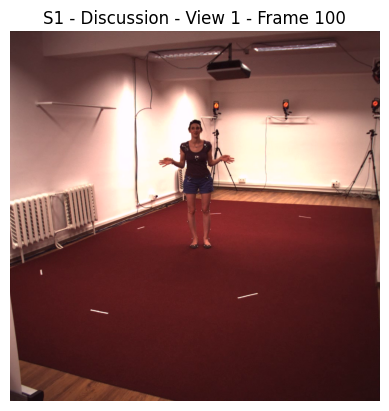

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# === Settings ===
subject = 'S1'
action = 'Discussion'
view_2d = 1       # Camera view index: 0, 1, 2, or 3
frame_idx = 100   # Frame number you want to extract

# === Mapping from view index to camera ID ===there are 4 camera views
camera_id = {
    0: '54138969',
    1: '55011271',
    2: '58860488',
    3: '60457274'
}

# === Construct full path to the video ===
video_path = os.path.join(
    "C:/Users/z5512000/OneDrive - UNSW/dataset/human36", 
    subject, 
    "Videos", 
    f"{action}.{camera_id[view_2d]}.mp4"
)


# === Open video file ===
video = cv2.VideoCapture(video_path)

# === Seek to frame by setting time (50 fps → 20ms per frame) ===
timestamp = frame_idx * 20  # ms
video.set(cv2.CAP_PROP_POS_MSEC, timestamp)

# === Read frame ===
frame_exists, image = video.read()

if frame_exists:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'{subject} - {action} - View {view_2d} - Frame {frame_idx}')
    plt.axis('off')
    plt.show()
else:
    print(f"Frame {frame_idx} not found or video missing.")


### Mapping skeleton on top of the selected frame:

Skeleton data from data_2d_h36m_gt.npz is used. You can change view_2d value to see how pose looks like from different camera views.

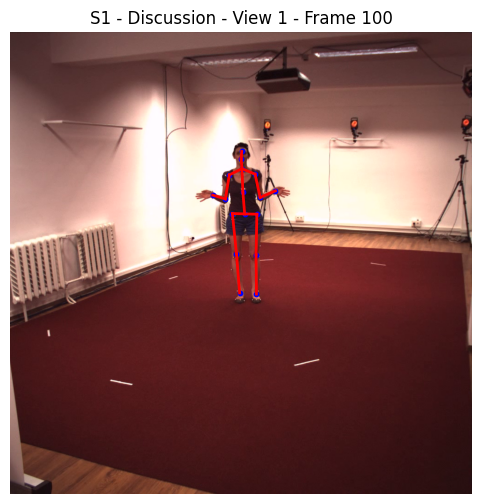

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# === Settings ===
data_2d_file = 'data_2d_h36m_gt.npz'
video_root = r"C:/Users/z5512000/OneDrive - UNSW/dataset/human36"
subject = 'S1'
action = 'Discussion'
view_2d = 1
frame_idx = 100

# === Camera ID mapping for Human3.6M ===
camera_id = {
    0: '54138969',
    1: '55011271',
    2: '58860488',
    3: '60457274',
}

# === Load 2D keypoints ===
data_2d_npz = np.load(data_2d_file, allow_pickle=True)
dataset_2d = data_2d_npz['positions_2d'].item()
data_2d = dataset_2d[subject][action][view_2d][frame_idx]  # (17, 2) for this frame

# === Load matching video frame ===
video_path = os.path.join(video_root, subject, 'Videos', f"{action}.{camera_id[view_2d]}.mp4")
cap = cv2.VideoCapture(video_path)
timestamp = frame_idx * 20  # 50 fps → 20 ms/frame
cap.set(cv2.CAP_PROP_POS_MSEC, timestamp)
success, image = cap.read()
cap.release()

if not success:
    raise RuntimeError("Could not read frame from video")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === Joint connections (Human3.6M format) ===
bones = [
    [0,1], [1,2], [2,3],     # right leg
    [0,4], [4,5], [5,6],     # left leg
    [0,7], [7,8], [8,9], [9,10],  # spine to head
    [8,11], [11,12], [12,13],     # left arm
    [8,14], [14,15], [15,16]      # right arm
]

# === Draw ground truth 2D skeleton on the image ===
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.xlim([0, 1000])
plt.ylim([1000, 0])  # Flip y-axis for correct alignment

# Draw bones
for s, e in bones:
    x = [data_2d[s][0], data_2d[e][0]]
    y = [data_2d[s][1], data_2d[e][1]]
    plt.plot(x, y, c='r', linewidth=2)

# Draw joints
for joint in data_2d:
    plt.scatter(joint[0], joint[1], c='blue', s=10)

plt.title(f"{subject} - {action} - View {view_2d} - Frame {frame_idx}")
plt.axis('off')
plt.show()


### From another view from a different camera:

Here we choose view_2d = 3 which represent camera '60457274'.

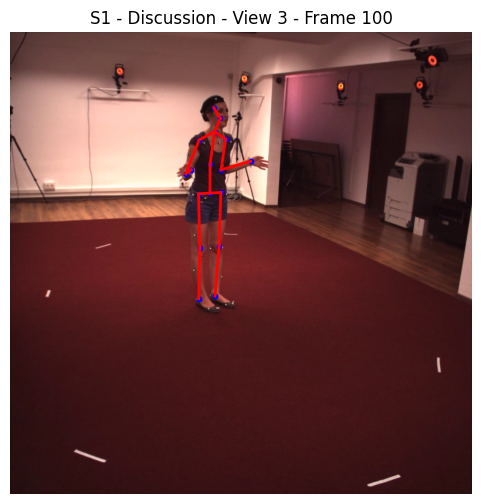

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# === Settings ===
data_2d_file = 'data_2d_h36m_gt.npz'
video_root = r"C:/Users/z5512000/OneDrive - UNSW/dataset/human36"
subject = 'S1'
action = 'Discussion'
view_2d = 3
frame_idx = 100

# === Camera ID mapping for Human3.6M ===
camera_id = {
    0: '54138969',
    1: '55011271',
    2: '58860488',
    3: '60457274',
}

# === Load 2D keypoints ===
data_2d_npz = np.load(data_2d_file, allow_pickle=True)
dataset_2d = data_2d_npz['positions_2d'].item()
data_2d = dataset_2d[subject][action][view_2d][frame_idx]  # (17, 2) for this frame

# === Load matching video frame ===
video_path = os.path.join(video_root, subject, 'Videos', f"{action}.{camera_id[view_2d]}.mp4")
cap = cv2.VideoCapture(video_path)
timestamp = frame_idx * 20  # 50 fps → 20 ms/frame
cap.set(cv2.CAP_PROP_POS_MSEC, timestamp)
success, image = cap.read()
cap.release()

if not success:
    raise RuntimeError("Could not read frame from video")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === Joint connections (Human3.6M format) ===
bones = [
    [0,1], [1,2], [2,3],     # right leg
    [0,4], [4,5], [5,6],     # left leg
    [0,7], [7,8], [8,9], [9,10],  # spine to head
    [8,11], [11,12], [12,13],     # left arm
    [8,14], [14,15], [15,16]      # right arm
]

# === Draw ground truth 2D skeleton on the image ===
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.xlim([0, 1000])
plt.ylim([1000, 0])  # Flip y-axis for correct alignment

# Draw bones
for s, e in bones:
    x = [data_2d[s][0], data_2d[e][0]]
    y = [data_2d[s][1], data_2d[e][1]]
    plt.plot(x, y, c='r', linewidth=2)

# Draw joints
for joint in data_2d:
    plt.scatter(joint[0], joint[1], c='blue', s=10)

plt.title(f"{subject} - {action} - View {view_2d} - Frame {frame_idx}")
plt.axis('off')
plt.show()


## Overlay the 2D skeleton on top of a video frame-by-frame:

Here we open a particular video and map skeleton on top of the person.

Press q to quit the video.

In [21]:
#can change camera from 1 to 4 using view_2d = 1  # camera index: 0~3
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

# === Config ===
subject = 'S1'
action = 'Smoking'
view_2d = 3  # camera index: 0~3
camera_id = ['54138969', '55011271', '58860488', '60457274']
frame_rate = 50  # Human3.6M video frame rate (20ms per frame)
dataset_2d_file = 'data_2d_h36m_gt.npz'

# Load dataset
dataset_2d = np.load(dataset_2d_file, allow_pickle=True)['positions_2d'].item()

# Video path
video_path = f"C:/Users/z5512000/OneDrive - UNSW/dataset/human36/{subject}/Videos/{action}.{camera_id[view_2d]}.mp4"
cap = cv2.VideoCapture(video_path)

# === Bones connection (17-joint Human3.6M) ===
bones = [
    [0,1],[1,2],[2,3],[0,4],[4,5],[5,6],
    [0,7],[7,8],[8,9],[9,10],[8,11],[11,12],[12,13],
    [8,14],[14,15],[15,16]
]

# === Get keypoint sequence ===
keypoints_seq = dataset_2d[subject][action][view_2d]  # shape: [frames, 17, 2]
total_frames = len(keypoints_seq)

# === Create Video Writer if saving is needed ===
save_output = False
if save_output:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output_with_skeleton.mp4', fourcc, frame_rate, (1000, 1000))

# === Draw skeleton on each frame ===
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_idx >= total_frames:
        break

    # Resize to 1000x1000 for visualization (Human3.6M default res)
    frame = cv2.resize(frame, (1000, 1000))

    # Draw skeleton on image
    skeleton_img = frame.copy()
    keypoints = keypoints_seq[frame_idx]

    for bone in bones:
        s, e = bone
        x1, y1 = int(keypoints[s][0]), int(keypoints[s][1])
        x2, y2 = int(keypoints[e][0]), int(keypoints[e][1])
        cv2.line(skeleton_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    for j in keypoints:
        x, y = int(j[0]), int(j[1])
        cv2.circle(skeleton_img, (x, y), 3, (255, 0, 0), -1)

    # Show frame
    cv2.imshow('2D Skeleton Overlay', skeleton_img)
    
    if save_output:
        out.write(skeleton_img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_idx += 1

cap.release()
if save_output:
    out.release()
cv2.destroyAllWindows()


### Plotting a 3D Skeleton for a Frame

For 3D no need to mention camera view.

3D data is in world coordinate form.

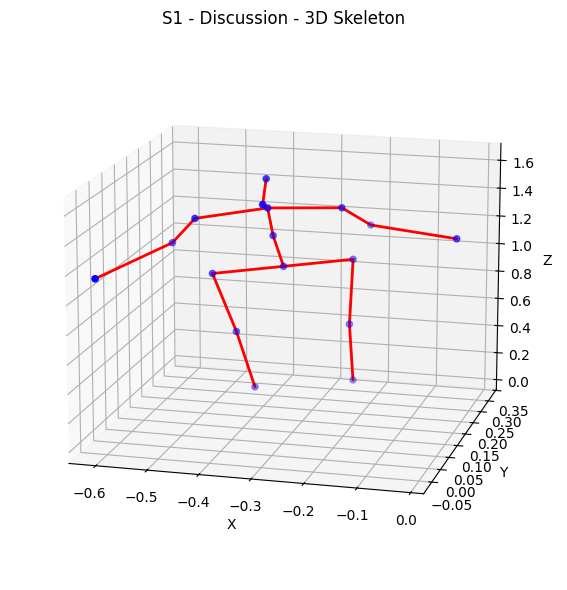

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
import numpy as np

# === Select same parameters ===
subject = 'S1'
action = 'Discussion'
frame_idx = 100

# === Load 3D joint coordinates ===
data_3d = dataset_3d[subject][action]['positions'][frame_idx]  # (17, 3)

# === Define the skeleton bones ===
bones = [
    [0,1],[1,2],[2,3],[0,4],[4,5],[5,6],
    [0,7],[7,8],[8,9],[9,10],[8,11],[11,12],[12,13],
    [8,14],[14,15],[15,16]
]

# === Plot ===
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot bones (red lines)
for bone in bones:
    s, e = bone
    x = [data_3d[s][0], data_3d[e][0]]
    y = [data_3d[s][1], data_3d[e][1]]
    z = [data_3d[s][2], data_3d[e][2]]
    ax.plot(x, y, z, c='r', linewidth=2)

# Plot joints as blue dots
ax.scatter(data_3d[:,0], data_3d[:,1], data_3d[:,2], c='blue', s=20)

# Set view limits and labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f"{subject} - {action} - 3D Skeleton")
#ax.view_init(elev=30, azim=-30)  # from gi
ax.view_init(elev=15, azim=-75)  # adjust view angle

plt.tight_layout()
plt.show()


In [28]:
subject = 'S1'
action = 'Smoking'
frame_idx = 100

data_3d = dataset_3d[subject][action]['positions'][frame_idx]
data_3d

array([[-0.0783266 , -0.16242   ,  0.940099  ],
       [-0.21088575, -0.156166  ,  0.948117  ],
       [-0.17553662, -0.126362  ,  0.5076425 ],
       [-0.15521166, -0.06389793,  0.05821105],
       [ 0.05423278, -0.168674  ,  0.932081  ],
       [ 0.05533141, -0.16319399,  0.48922184],
       [ 0.0808828 , -0.10095847,  0.04002532],
       [-0.08963297, -0.12000001,  1.1694095 ],
       [-0.0962164 , -0.12311961,  1.4263839 ],
       [-0.15867679, -0.19890411,  1.4972999 ],
       [-0.15767922, -0.16035117,  1.6056429 ],
       [ 0.04048261, -0.13393563,  1.3630773 ],
       [ 0.13228881, -0.11496272,  1.1004231 ],
       [ 0.19209294, -0.2017861 ,  0.87182975],
       [-0.22655031, -0.08904244,  1.3581028 ],
       [-0.31319866, -0.06435531,  1.0941637 ],
       [-0.31727594, -0.3146815 ,  1.0679433 ]], dtype=float32)

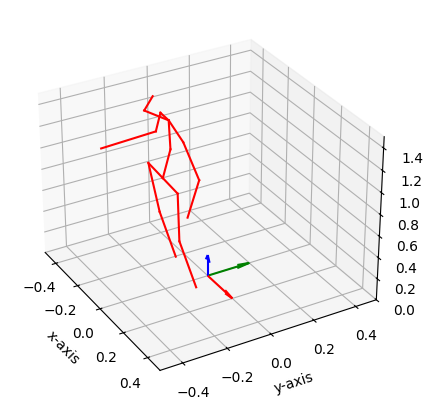

In [29]:
# draw 3d skeleton
fig = plt.figure(figsize=(5,5)) #figsize=(20,20)
ax = fig.add_subplot(projection='3d')
ax.set_aspect('auto') ##############
ax.view_init(30, -30)

ax.set_zlim(0, 1.5)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

ax.quiver(0,0,0,0.2,0,0, color='r') #x-axis
ax.quiver(0,0,0,0,0.2,0, color='g') #y-axis
ax.quiver(0,0,0,0,0,0.2, color='b') #z-axis
for bone in bones:
    s = bone[0]
    e = bone[1]

    col = 'red'

    x = [(data_3d[s][0]), (data_3d[e][0])]
    y = [(data_3d[s][1]), (data_3d[e][1])]
    z = [(data_3d[s][2]), (data_3d[e][2])]

    ax.plot(x, y, z, c = col)


plt.show()

In [30]:
data_2d

array([[432.87674, 348.68616],
       [408.18954, 350.1935 ],
       [410.61365, 466.9772 ],
       [408.47147, 577.766  ],
       [456.40546, 347.27368],
       [452.59988, 462.55276],
       [443.94968, 571.3313 ],
       [433.0762 , 285.51807],
       [443.11127, 215.49814],
       [455.26718, 186.94536],
       [441.05618, 163.7334 ],
       [466.6657 , 231.91498],
       [456.87848, 298.3055 ],
       [520.8465 , 279.80096],
       [409.25497, 233.78386],
       [380.95013, 306.6232 ],
       [392.71585, 298.3204 ]], dtype=float32)